<a href="https://colab.research.google.com/github/maryamhashemi/Persian_VQA/blob/master/persian_VQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Prerequesties

In [1]:
! pip install arabic_reshaper 
! pip install python-bidi

In [0]:
import os
import re
import json
import numpy as np
from PIL import Image
import arabic_reshaper
from collections import Counter
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Multiply, Input

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Set Parameters

In [0]:
DROPOUT_RATE = 0.5
EMBEDDING_DIM = 100
EPOCHS = 50
BATCH_SIZE = 64
SEQ_LENGTH = 40
VOCAB_SIZE = 1000
OOV_TOK = "<OOV>"

BASE_PATH = '/content/drive/My Drive/Persian_VQA/'
QUESTION_TRAIN_PATH =   os.path.join(BASE_PATH, 'google-train_questions.json')
ANNOTATION_TRAIN_PATH = os.path.join(BASE_PATH, 'google-train-annotations.json')
IMAGE_TRAIN_PATH = os.path.join(BASE_PATH, 'train_images_1000')

QUESTION_VAL_PATH =   os.path.join(BASE_PATH, '...')
ANNOTATION_VAL_PATH = os.path.join(BASE_PATH, '...')
IMAGE_VAL_PATH = os.path.join(BASE_PATH, 'val_images_500')

QUESTION_TEST_PATH =   os.path.join(BASE_PATH, '...')
ANNOTATION_TEST_PATH = os.path.join(BASE_PATH, '...')
IMAGE_TEST_PATH = os.path.join(BASE_PATH, 'val_images_500')

### Read Data

In [0]:
def read_image_paths(dir_path):
  ims = {}

  for filename in os.listdir(dir_path):
    if filename.endswith('.jpg'):
      image_id = int(re.findall('\d+', filename)[1])
      ims[image_id] = os.path.join(dir_path, filename)

  return ims

In [0]:
def load_and_proccess_image(image_path, model):
  im = load_img(image_path, target_size=(224,224,3))
  x = img_to_array(im)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  features = model.predict(x)

  return features[0]

In [0]:
def read_images(paths):
  ims = {}
  base_model = VGG19(weights='imagenet', include_top=True)
  model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

  for image_id, image_path in paths.items():
    ims[image_id] = load_and_proccess_image(image_path, model)
  return ims

In [0]:
def get_train_image_paths():
  return read_image_paths(IMAGE_TRAIN_PATH)

In [0]:
def get_val_image_paths():
  return read_image_paths(IMAGE_VAL_PATH)

In [0]:
def get_test_image_paths():
  return read_image_paths(IMAGE_TEST_PATH)

In [0]:
def create_dataset(ims, qus, ann):
  qs = []
  answers = []
  qs_id = []
  im_id = []

  for q in qus['questions']:
    if q['image_id'] in ims.keys():
      qs.append(q['question'])
      qs_id.append(q['question_id'])
      im_id.append(q['image_id'])

  for ann in ann['annotations']:
    if ann['question_id'] in qs_id:
      answer_counts = Counter(a['answer'] for a in ann['answers'])
      answers.append(answer_counts.most_common(1)[0][0])

  return qs, answers, qs_id, im_id

In [0]:
def get_train_dataset():
  ims = get_train_image_paths()
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs, ann)

In [0]:
def get_val_dataset():
  ims = get_val_image_paths()
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs, ann)

In [0]:
def get_test_dataset():
  ims = get_test_image_paths()
  qs = json.load( open(QUESTION_TRAIN_PATH))
  ann = json.load( open(ANNOTATION_TRAIN_PATH))
  
  return create_dataset(ims, qs, ann)

In [0]:
def get_answers(answers):
  all_answers = np.unique(answers)

  answer_counts = Counter(a for a in train_answers)
  all_answers =[a[0] for a in answer_counts.most_common(300)]

  return all_answers

#### Visualize Data

In [0]:
def show_visualqa(qs, answer, image):
  im = Image.open(image)  
  plt.figure()
  plt.imshow(im)
  title = arabic_reshaper.reshape(qs + "\n" + answer)
  title = get_display(title) 
  plt.title(title)
  plt.axis('off')
  plt.show()

def visualize_train(num):
  ims = get_train_image_paths()
  show_visualqa(train_qs[num], train_answers[num], ims.get(train_image_ids[num]))

def visualize_test(num):
  ims = get_test_image_paths()
  show_visualqa(test_qs[num], test_answers[num], ims.get(train_image_ids[num]))

In [17]:
train_qs, train_answers, train_q_ids, train_image_ids = get_train_dataset()
val_qs, val_answers, val_q_ids, val_image_ids = get_val_dataset()
test_qs, test_answers, test_q_ids, test_image_ids = get_test_dataset()

print(len(train_qs))
print(len(train_answers))
print(len(train_q_ids))
print(len(train_image_ids))

print(len(val_qs))
print(len(val_answers))
print(len(val_q_ids))
print(len(val_image_ids))

print(len(test_qs))
print(len(test_answers))
print(len(test_q_ids))
print(len(test_image_ids))

3000
3000
3000
3000
1500
1500
1500
1500
1500
1500
1500
1500


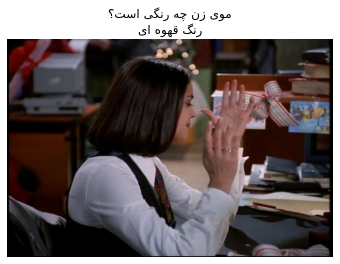

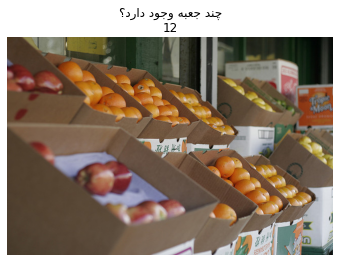

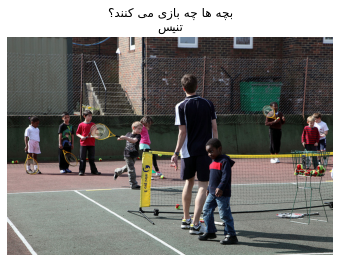

In [38]:
visualize_train(1100)
visualize_train(2200)
visualize_train(600)

#### Prepare questions to feed into network

In [0]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)
word_index = tokenizer.word_index
tokenizer.fit_on_texts(train_qs)

train_X_seqs = tokenizer.texts_to_sequences(train_qs)
val_X_seqs = tokenizer.texts_to_sequences(val_qs)
test_X_seqs = tokenizer.texts_to_sequences(test_qs)

train_X_seqs = pad_sequences(train_X_seqs, maxlen=SEQ_LENGTH, padding='post')
val_X_seqs = pad_sequences(val_X_seqs, maxlen=SEQ_LENGTH, padding='post')
test_X_seqs = pad_sequences(test_X_seqs, maxlen=SEQ_LENGTH, padding='post')

train_X_seqs = np.array(train_X_seqs)
val_X_seqs = np.array(val_X_seqs)
test_X_seqs = np.array(test_X_seqs)

#### Prepare images to feed into network

In [0]:
train_ims = read_images(get_train_image_paths())
val_ims = read_images(get_val_image_paths())
test_ims = read_images(get_test_image_paths())

train_X_ims = [train_ims[id] for id in train_image_ids]
val_X_ims = [val_ims[id] for id in val_image_ids]
test_X_ims = [test_ims[id] for id in test_image_ids]

train_X_ims = np.array(train_X_ims)
val_X_ims = np.array(val_X_ims)
test_X_ims = np.array(test_X_ims)

In [0]:
np.save(BASE_PATH + 'train_X_ims.npy',train_X_ims)
np.save(BASE_PATH + 'val_X_ims.npy',val_X_ims)
np.save(BASE_PATH + 'test_X_ims.npy',test_X_ims)

In [0]:
train_X_ims = np.load(BASE_PATH + 'train_X_ims.npy')
val_X_ims = np.load(BASE_PATH + 'val_X_ims.npy')
test_X_ims = np.load(BASE_PATH + 'test_X_ims.npy')

In [21]:
print(train_X_ims.shape)
print(val_X_ims.shape)
print(test_X_ims.shape)

(3000, 4096)
(1500, 4096)
(1500, 4096)


#### Prepare labels of data.

In [22]:
all_answers = get_answers(train_answers)
num_answers = len(all_answers)
num_classes = num_answers +1 

train_answer_indices = []
val_answer_indices = []
test_answer_indices = []

for a in train_answers:
  if a in all_answers:
    train_answer_indices.append(all_answers.index(a))
  else:
    train_answer_indices.append(num_answers)
 

for a in val_answers:
  if a in all_answers:
    val_answer_indices.append(all_answers.index(a))
  else: 
    val_answer_indices.append(num_answers)

for a in test_answers:
  if a in all_answers:
    test_answer_indices.append(all_answers.index(a))
  else:
    test_answer_indices.append(num_answers)

train_Y = to_categorical(train_answer_indices)
val_Y = to_categorical(val_answer_indices)
test_Y = to_categorical(test_answer_indices)

print(train_Y.shape)
print(val_Y.shape)

(3000, 301)
(1500, 301)


### Build Vanilla Network

In [0]:
def img_model(img_input):
  x = Dense(1024, activation='tanh', input_dim = 4096)(img_input)

  return x

In [0]:
def qs_model(qs_input, num_words, embedding_dim, dropout_rate):

  x = Embedding(num_words, embedding_dim, input_length=SEQ_LENGTH, trainable = True)(qs_input)
  x = LSTM(units=512, return_sequences=True, input_shape= (None,embedding_dim))(x)
  x = Dropout(dropout_rate)(x)
  x = LSTM(units=512, return_sequences=False)(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(1024, activation='tanh')(x)

  return x

In [0]:
def vanilla(num_classes, dropout_rate, num_words, embedding_dim):
  qs_input = Input(shape=(SEQ_LENGTH,))
  img_input = Input(shape=(4096,))

  CNN_model = img_model(img_input)
  LSTM_model = qs_model(qs_input, num_words, embedding_dim, dropout_rate)

  x = Multiply()([CNN_model, LSTM_model])
  x = Dropout(dropout_rate)(x)
  x = Dense(1000, activation='tanh')(x)
  x = Dropout(dropout_rate)(x)
  output = Dense(num_classes, activation='softmax')(x)
  
  model = Model(inputs= [qs_input, img_input], outputs= output)
  return model

### Train

In [0]:
def Train():
  checkpoint = ModelCheckpoint('model.h5', save_best_only=True)

  model = vanilla(num_classes, DROPOUT_RATE, VOCAB_SIZE, EMBEDDING_DIM)
  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  history = model.fit([train_X_seqs,train_X_ims] ,
                      train_Y, 
                      epochs = EPOCHS, 
                      batch_size = BATCH_SIZE, 
                      callbacks = [checkpoint],
                      validation_data=([val_X_seqs,val_X_ims], val_Y) )
  return history, model


In [31]:
history, model = Train()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 100)      100000      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 40, 512)      1255424     embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 40, 512)      0           lstm_2[0][0]                     
____________________________________________________________________________________________

In [0]:
def plot_accuracy_loss(history):
  acc      = history.history[     'accuracy' ]
  val_acc  = history.history[ 'val_accuracy' ]
  loss     = history.history[    'loss' ]
  val_loss = history.history['val_loss' ]

  epochs   = range(len(acc))

  plt.plot  ( epochs,     acc, label='train_acc' )
  plt.plot  ( epochs, val_acc, label='val_acc' )
  plt.title ('Training and validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.savefig(BASE_PATH + 'Training and validation accuracy.jpg')
  plt.figure()

  plt.plot  ( epochs,     loss, label='train_loss' )
  plt.plot  ( epochs, val_loss, label='val_loss' )
  plt.title ('Training and validation loss'   )
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.savefig(BASE_PATH + 'Training and validation loss.jpg')

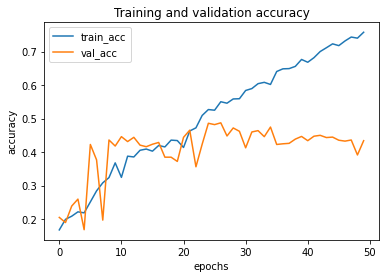

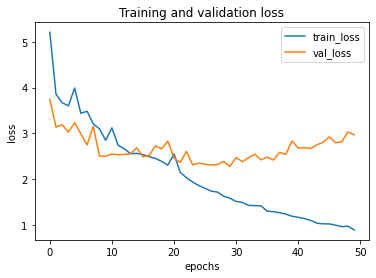

In [36]:
plot_accuracy_loss(history)

### Evaluate

In [34]:
def Evaluation(model):
  results = model.evaluate([test_X_seqs,test_X_ims], test_Y, batch_size=64)
  print('test loss, test acc:', results)
Evaluation(model)

24/24 [==============================] - 0s 9ms/step - loss: 2.9684 - accuracy: 0.4340
test loss, test acc: [2.968400001525879, 0.4339999854564667]


In [0]:
def predict(model):
  prediction = predict = model.predict([test_X_seqs,test_X_ims])
  
  # y_pred = []
  # for p in prediction:
  #   y_pred.append(np.argmax(p))
  # y_pred = np.array(y_pred)
  # print(np.where(y_pred == test_answer_indices))
  return prediction

def compare_truth_pred(prediction, num):
  index = np.argmax(prediction[num])
  if(index == num_classes -1):
    show_visualqa(test_qs[num],'نمیدونم', get_test_image_paths().get(test_image_ids[num]))
  else:
    show_visualqa(test_qs[num],all_answers[index], get_test_image_paths().get(test_image_ids[num]))
  show_visualqa(test_qs[num],test_answers[num], get_test_image_paths().get(test_image_ids[num]))

In [94]:
pred = predict(model)

(array([   1,    6,    7,    9,   10,   11,   13,   17,   18,   22,   25,
         26,   28,   29,   31,   32,   34,   44,   45,   49,   51,   52,
         53,   60,   61,   65,   67,   69,   72,   74,   75,   77,   80,
         81,   82,   85,   90,   94,   98,   99,  100,  102,  107,  109,
        110,  111,  114,  119,  122,  125,  126,  127,  129,  130,  131,
        132,  135,  136,  139,  140,  142,  145,  151,  154,  159,  163,
        166,  169,  171,  172,  175,  176,  178,  179,  182,  184,  185,
        187,  188,  190,  191,  192,  193,  194,  195,  197,  198,  200,
        203,  204,  207,  210,  214,  227,  229,  231,  234,  237,  241,
        242,  243,  245,  247,  249,  254,  260,  262,  268,  272,  276,
        277,  279,  280,  281,  285,  290,  291,  296,  297,  298,  305,
        306,  307,  312,  315,  319,  321,  322,  325,  331,  333,  334,
        335,  336,  337,  338,  339,  341,  345,  346,  348,  350,  352,
        354,  357,  360,  361,  363,  366,  368,  

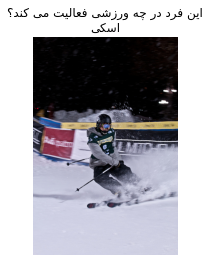

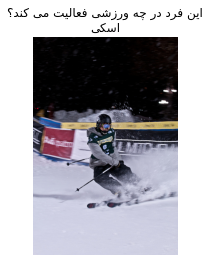

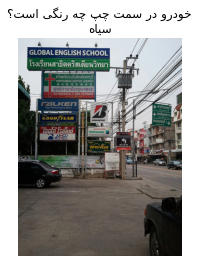

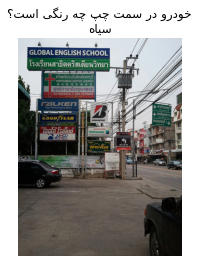

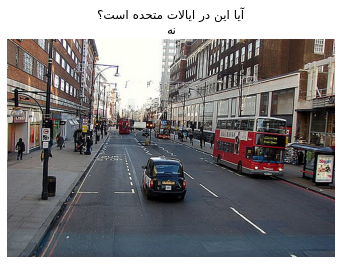

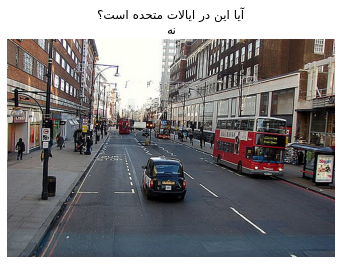

In [106]:
compare_truth_pred(pred,60)
compare_truth_pred(pred,75)
compare_truth_pred(pred,711)

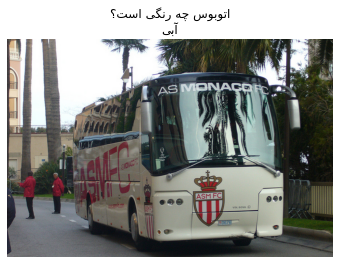

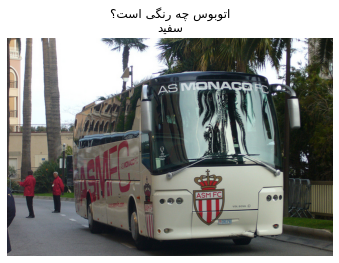

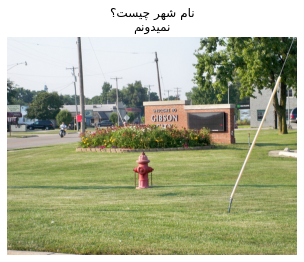

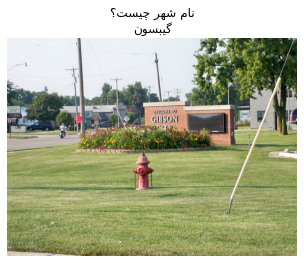

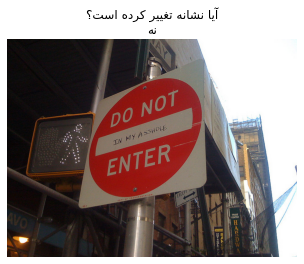

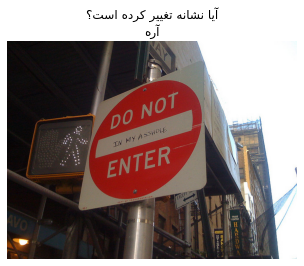

In [112]:
compare_truth_pred(pred,0)
compare_truth_pred(pred,600)
compare_truth_pred(pred,800)